# TASK-2 
### Implement the pose normalisation of reference mesh from the following section (3.1.1) quoted in the paper:

"Using the reference vertices, we define a reference cylindrical coordinate system (similar to [4]) 
with a vertical axis such that most face vertices are equidistant to the axis. 
We then scale the face size such that the eyes and nose project to fixed locations on this reference cylinder."

### References
1. Optimal wrapping on a cylinder - https://github.com/menpo/menpo3d/blob/master/menpo3d/unwrap.py
2. Proper extraction of atlas map - https://github.com/google/mediapipe/issues/3790
3. Sample execution in polar cord - https://github.com/google/mediapipe/issues/1698 ; https://github.com/apple2373/mediapipe-facemesh/blob/main/main.ipynb
4. Umeyama alg impl. code snippet - https://github.com/longredzhong/LipSync3D/blob/master/lipsync3d/utils.py

In [1]:
import matplotlib.pyplot as plt
import os
import json
import cv2
import skimage
import numpy as np
import mediapipe as mp
from skimage.transform import PiecewiseAffineTransform, warp

from menpo.transform import Transform, Translation
from menpo.shape import PointCloud
from menpo3d.unwrap import CylindricalUnwrap
from scipy import optimize
from collections import namedtuple

def imshow(img):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    return ax

%matplotlib qt

In [2]:
def get_keypoints_and_vis(img, plot=True):
    """Get the facial landmarks and plot the same onto the image
    :img: np.arr -> pass the image as a numpy array 
    :plot: bool  -> pass a boolean to mention whether to show the plot with landmark overlay
    
    :ret: keyp_scal:np.arr, keyp_cart:np.arr -> keypoints, keypoints3d
    """
    H,W,_ = img.shape
    #run facial landmark detection
    with mp.solutions.face_mesh.FaceMesh(
            static_image_mode=True,
            refine_landmarks=True,
            max_num_faces=1,
            min_detection_confidence=0.5) as face_mesh:
        results = face_mesh.process(img)
    
    assert len(results.multi_face_landmarks)==1 
    
    face_landmarks = results.multi_face_landmarks[0]
    keyp_scal = np.array([(W*point.x,H*point.y) for point in face_landmarks.landmark[0:468]])#after 468 is iris or something else
    keyp_cart = np.array([(point.x, point.y, point.z) for point in face_landmarks.landmark[0:468]])

    if plot:
        ax = imshow(img)
        ax.plot(keyp_scal[:, 0], keyp_scal[:, 1], '.b', markersize=2)
        plt.show()

    return keyp_scal, keyp_cart

In [3]:
## Generating cylindrical UV map from the acquired landmarks
## Refer https://github.com/menpo/menpo3d/blob/master/menpo3d/math.py
RadialFitResult = namedtuple("RadialFitResult", ["centre", "radius"])
def radial_fit(p):
    """
    Find the least squares radial fitting a set of ND points.

    Parameters
    ----------
    p : ``(N, D)`` `ndarray`
        Points to find find centre of

    Returns
    -------
    centre_i : (D,) `ndarray`
        The ND coordinates of the centre of the circle.
    r_i : `float`
        The radius of the circle.

    References
    ----------
    .. [1] http://www.scipy.org/Cookbook/Least_Squares_Circle

    """

    def error(tuple_c, x):
        c = np.array(tuple_c)
        err = r(x, c)
        return err - err.mean()

    r = lambda x, c: np.sqrt(np.sum((x - c) ** 2, axis=1))
    av_r = lambda x, c: np.mean(r(x, c))
    c_est = np.mean(p, axis=0)
    c_i, ier = optimize.leastsq(error, c_est, args=p)
    return RadialFitResult(centre=c_i, radius=av_r(p, c_i))

In [4]:
# Helper function for converting Landmarks to dict
def landmark_to_dict(landmark_list):
    landmark_dict = {}
    for idx, landmark in enumerate(landmark_list):
        landmark_dict[idx] = [landmark.x, landmark.y, landmark.z]

    return landmark_dict

# Convert Landmark dict to np.array
def dict_to_pcd(reference_dict):
    reference_mesh = np.empty((0,3), int)
    for i in range(len(reference_dict)):
        row = np.array(reference_dict[i])
        reference_mesh = np.vstack([reference_mesh,row])
    return reference_mesh

# Convert pcd to dict
def pcd_to_dict(pcd):
    landmark_dict = {}
    for idx, landmark in enumerate(pcd):
        landmark_dict[idx] = list(landmark)

    return landmark_dict

def cyl2cart(cy_coords, radius):
    """Convert cylindrical to cartesian coordinates
    :cy_coords: np.arr -> pass the N-D numpy array for cylindrical coordinates 
    :radius: float     -> radius of the cylinder considered
    
    ret: np.arr -> N-D array of cartesian coordinates
    """
    cart_coords = np.zeros_like(cy_coords)
    # element wise multiply 
    cart_coords[:, 0] = (cy_coords[:, 2] + radius)*np.sin(cy_coords[:, 0] / radius)
    cart_coords[:, 2] = (cy_coords[:, 2] + radius)*np.cos(cy_coords[:, 0] / radius)
    cart_coords[:, 1] = cy_coords[:, 1]
    return cart_coords

In [5]:
# Umeyama algorithm to rotate and translate two similar sets of points for alignment
# Refer https://github.com/longredzhong/LipSync3D/blob/master/lipsync3d/utils.py
def Umeyama_algorithm(reference, target):
    """Realigns target pointcloud to reference pointcloud
    :reference: np.arr -> pass the N-D numpy array for reference pcd 
    :target: np.arr    -> pass the N-D numpy array for target pcd
    
    :ret: R:np.arr, t:np.arr, c:float -> N-D arrays returned for realignment of target
    realigned_target = c * (R @ target) + t
    """
    # idx 2 -> nose, 130 -> left eye, 359 -> right eye
    idx_list = [2, 94, 19, 1, 4, 5, 195, 197, 6, 168, 8, 9, 151, 10, 109, 108, 67, 69, 103, 104, 54, 68, 338, 337, 297, 299, 332, 333, 284, 298, 130, 243, 244, 359, 362, 463,
                21, 71, 162, 139, 156, 70, 63, 105, 66, 107, 336, 296, 334, 293, 300, 301, 251, 55, 285, 193, 417, 122, 351, 196, 419, 3, 248, 51, 281,
                45, 275, 44, 274, 220, 440, 134, 363, 236, 456]

    # idx_list_mouth = [62, 78, 191, 95, 80, 88, 81, 178, 82, 87, 13, 14, 312, 317, 311, 402, 310, 318, 415, 324, 308, 293]
    # idx_list = [19, 243, 463]
    
    ref_points = []
    tgt_points = []

    for idx in idx_list:
        ref_points.append(reference[idx])
        tgt_points.append(target[idx])

    ref_points = np.array(ref_points)
    tgt_points = np.array(tgt_points)

    ref_mu = ref_points.mean(axis=0)
    tgt_mu = tgt_points.mean(axis=0)
    ref_var = ref_points.var(axis=0).sum()
    tgt_var = tgt_points.var(axis=0).sum()
    n, m = ref_points.shape
    covar = np.matmul((ref_points - ref_mu).T, tgt_points - tgt_mu) / n
    det_covar = np.linalg.det(covar)
    u, d, vh = np.linalg.svd(covar)
    detuv = np.linalg.det(u) * np.linalg.det(vh.T)
    cov_rank = np.linalg.matrix_rank(covar)
    S = np.identity(m)

    if cov_rank > m - 1:
        if det_covar < 0:
            S[m - 1, m - 1] = -1
    else: 
        if detuv < 0:
            S[m - 1, m - 1] = -1

    R = np.matmul(np.matmul(u, S), vh)
    c = (1 / tgt_var) * np.trace(np.matmul(np.diag(d), S))
    t = ref_mu.reshape(3, 1) - c * np.matmul(R, tgt_mu.reshape(3, 1))

    return R, t, c

### Flowchart of essentially whats happening except the Umeyama orientation step

1. Obtain the face point cloud
2. Get optimal radius and center of cylinder by using the x-z plane data
3. Project the face onto the cylinder surface
4. Unroll the points onto x-y plane
   
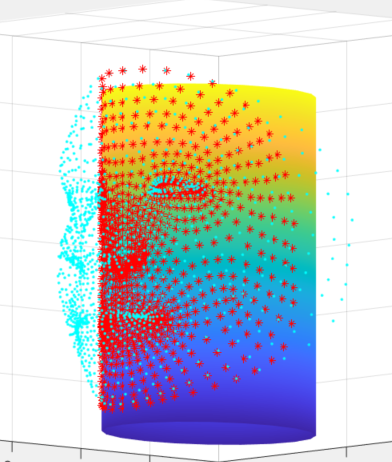
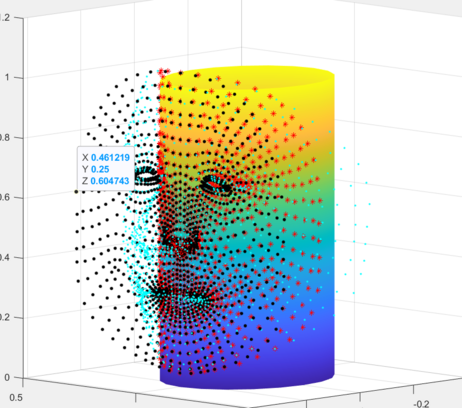

In [6]:
def get_unwrapped_atlas(img_arr, keyp_cart_norm=None, atlas_res = (256, 256)):
    keyp_scal, keyp_cart = get_keypoints_and_vis(img_arr)
    # ref1_keyp_scaled, ref1_keyp_cart = get_keypoints_and_vis(img_ref1)

    if keyp_cart_norm is not None:
        keyp_cart = keyp_cart_norm
    
    keyp_cart_pcd = PointCloud(keyp_cart)
    keyp_cart_pcd.view()
    
    # find the optimum centre and radius to unwrap
    xz = keyp_cart[:, [0, 2]]  # just in the x-z plane
    centre, radius = radial_fit(xz)
    
    # shift the optimal center for proper unwrap projection
    translation = np.array([centre[0], 0, centre[1]])
    centring_transform = Translation(-translation)
    unwrap = centring_transform.compose_before(CylindricalUnwrap(radius))
    unwrapped_mesh_cyl = unwrap.apply(keyp_cart_pcd)
    unwrapped_mesh_cyl = unwrapped_mesh_cyl.points
    
    # Delete depth information in cylindrical coords
    unwrapped_mesh_cyl[:, 2] = 0
    unwrapped_mesh_cart = cyl2cart(unwrapped_mesh_cyl, radius)
    unwrapped_mesh_cart = PointCloud(unwrapped_mesh_cart)
    
    # Shift the center back to original coordinates 
    centring_transform = Translation(translation)
    unwrapped_mesh_cart = centring_transform.apply(unwrapped_mesh_cart)
    unwrapped_mesh_cart.view()
    # Create atlas map
    H_new, W_new = atlas_res
    uv_map = unwrapped_mesh_cart.points[:, [0,1]]
    keypoints_uv = np.array([(W_new*x, H_new*y) for x,y in uv_map])
    
    # https://scikit-image.org/docs/dev/auto_examples/transform/plot_piecewise_affine.html
    tform = PiecewiseAffineTransform()
    tform.estimate(keypoints_uv,keyp_scal)
    texture = warp(img_arr, tform, output_shape=(H_new,W_new))
    texture = (255*texture).astype(np.uint8)
    
    ax = imshow(texture)
    ax.plot(keypoints_uv[:, 0], keypoints_uv[:, 1], '.b', markersize=2)
    plt.show()

In [7]:
img_ref1 = skimage.io.imread("./reference_frame.jpg")
img_ref2 = skimage.io.imread("./ref2.jpg")

img_ger1 = skimage.io.imread("./geralt/geralt1.jpg")
img_ger2 = skimage.io.imread("./geralt/geralt2.jpg")

img_gerf1 = skimage.io.imread("./geralt/geralt_ref1.jpg")
img_gerf2 = skimage.io.imread("./geralt/geralt_ref2.jpg")

In [8]:
def get_pose_normalised_atlas(ref_img_arr, tar_img_arr, atlas_res = (256, 256)):
    import math
    _, keyp_cart_ref = get_keypoints_and_vis(ref_img_arr, plot=False)
    _, keyp_cart_tar = get_keypoints_and_vis(tar_img_arr, plot=False)

    keyp_cart_ref_dict = pcd_to_dict(keyp_cart_ref)
    keyp_cart_tar_dict = pcd_to_dict(keyp_cart_tar)
    
    # Apply Umeyama algo for pose normalisation
    R, t, c = Umeyama_algorithm(reference=keyp_cart_ref_dict, target=keyp_cart_tar_dict)
    # norm = c * (R @ v) + t
    # v is a vertex of size (3,1)
    # So for batch processing (instead of slow for loops)
    # norm = (c * (R @ v.T) + t).T
    # norm = c * (v @ R.T) + t.T
    keyp_cart_tar = c * (keyp_cart_tar @ R.T) + t.T

    get_unwrapped_atlas(ref_img_arr)
    get_unwrapped_atlas(tar_img_arr, keyp_cart_tar)

In [ ]:
## Human faces
get_pose_normalised_atlas(img_ref2, img_ref1)

In [9]:
## Faces from games to see the consistency of the atlas map
## Warning... meme faces incoming
get_pose_normalised_atlas(img_ger1, img_ger2)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [10]:
## Faces from games to see the consistency of the atlas map
get_pose_normalised_atlas(img_gerf1, img_gerf2)